## Clustering evaluation

In [1]:
from datetime import datetime

import pandas as pd

from config import BASE_DIR

RERUN = True

In [2]:


clustering_label = "composition"
CHUNK_SIZE = 100
DATA_PATH = f"{BASE_DIR}/notebooks/data/filtered_text_and_starr_features_{CHUNK_SIZE}_words_nonbib_17_06_2024.csv"
df = pd.read_csv(DATA_PATH)


Our dataset contains chunks of 100 words (using scrolls that have more than 300 words and written in hebrew).
I will use 4 different vectorizers: Starr, trigrams, BERT, tf-idf. When our metric for clustering will be the dgapusta score.

## Hirerchial clustering 

In [3]:

from notebooks.notebooks_utils import set_seed_globaly

set_seed_globaly()

PATH = f"{BASE_DIR}/notebooks/reports/vis_for_jonathan"
FRAC = 1
CONTEXT_SIMILIARITY_WINDOW = 3
linkage_criterion = "ward"

In [4]:


from notebooks.clustering import get_dendrogram_feature_order, get_metrics_from_LCA
from notebooks.clustering_main import stratified_sample
from sklearn import cluster as sk
from notebooks.features import create_adjacency_matrix, vectorize_text, get_linkage_matrix
from scipy import sparse as sp
from sknetwork.hierarchy import dasgupta_score as calculate_dasgupta_score


def run_single_clustering(df, frac, context_similiarity_window, vectorizer_type, linkage_criterion):
    sampled_df = stratified_sample(df, 'book', frac=frac, random_state=42)
    print(f"{datetime.now()} - {sampled_df.shape=}")
    adjacency_matrix = create_adjacency_matrix(sampled_df, context_similiarity_window=context_similiarity_window,
                                               composition_level=True)

    vectorizer_matrix = vectorize_text(sampled_df, "text", vectorizer_type)
    print(f"{datetime.now()} - {vectorizer_type=},{vectorizer_matrix.shape=}")
    if sp.issparse(vectorizer_matrix):
        vectorizer_matrix = vectorizer_matrix.toarray()
    model = sk.AgglomerativeClustering(
        distance_threshold=0, n_clusters=None, linkage=linkage_criterion
    )
    model.fit_predict(vectorizer_matrix)
    linkage_matrix = get_linkage_matrix(model)

    dasgupta_score = calculate_dasgupta_score(adjacency_matrix, linkage_matrix)

    print(f"{dasgupta_score=}\n")

    feature_order = get_dendrogram_feature_order(linkage_matrix, df["sentence_path"].to_list())
    _, LCA_metric_mean, LCA_metric_std = get_metrics_from_LCA(feature_order)
    res = {'linkage_matrix': linkage_matrix,
           'sampled_df': sampled_df,
           'vectorizer_matrix': vectorizer_matrix,
           'adjacency_matrix': adjacency_matrix,
           'feature_order': feature_order,
           'model': model,
           'dasgupta_score': dasgupta_score,
           'LCA_metric_mean': LCA_metric_mean
           }
    return res




In [5]:
# HC for all vectorizers

all_models = {}
FRAC = 1
CONTEXT_SIMILIARITY_WINDOW = 3
linkage_criterion = "ward"
for vectorizer_type in ['dicta-il/BEREL', 'dicta-il/dictabert', 'trigram']:
    res = run_single_clustering(df, frac=FRAC, context_similiarity_window=CONTEXT_SIMILIARITY_WINDOW,
                                vectorizer_type=vectorizer_type, linkage_criterion=linkage_criterion)
    all_models[vectorizer_type] = res

2024-06-21 16:09:43.006128 - sampled_df.shape=(1365, 26)


Building adjacency matrix:   0%|          | 0/1365 [00:00<?, ?it/s]

2024-06-21 16:09:46.527240 - vectorizer_type='trigram',vectorizer_matrix.shape=(1365, 7363)
dasgupta_score=0.5462466686377527


### Treemap

Classic dendograms will a lot of data is pretty hard to analyze.
The use of tree-maps can make the evaluation much easier.

Here is an example of how dendogram will look as a treemap:


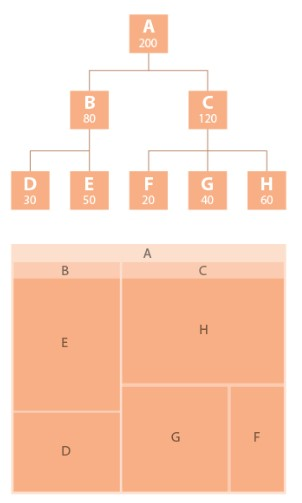

In [15]:

from notebooks.features import shorten_path
from anytree.importer import DictImporter
from scipy.cluster.hierarchy import fcluster
import plotly.express as px

import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from io import BytesIO
import base64


#taken from https://towardsdatascience.com/make-a-treemap-in-python-426cee6ee9b8


def create_df_for_treemap(res):
    linkage_matrix, sampled_df, vectorizer_matrix, adjacency_matrix, feature_order, model, dasgupta_score, LCA_metric_mean = [
        res[key] for key in
        ['linkage_matrix', 'sampled_df', 'vectorizer_matrix', 'adjacency_matrix', 'feature_order', 'model',
         'dasgupta_score', 'LCA_metric_mean']]

    # Create a recursive function to build the hierarchical structure
    def build_tree(node, children, names):
        if node < len(names):
            return {"name": names[node], "value": 1}
        else:
            node_children = children[node - len(names)]
            return {
                "name": f"node_{node}",
                "children": [build_tree(child, children, names) for child in node_children]
            }

    # Extract children from the model
    n_samples = len(model.labels_)
    children = model.children_

    # Use the real labels from df["sentence_path"]
    names = sampled_df["sentence_path"].apply(shorten_path).tolist()

    # Build the hierarchical tree starting from the root node
    root_node = n_samples + len(children) - 1
    tree = build_tree(root_node, children, names)

    importer = DictImporter()
    root = importer.import_(tree)

    size = []
    name = []
    parent = []
    level = []

    def format(node):
        for i in node.children:
            #check if node as attribute value
            if hasattr(i, 'value') == False:
                format(i)
            v = i.value
            #check if node parent as attribute value
            if hasattr(i.parent, 'value'):
                i.parent.value += v
            #if node parent doesn't have a value set to same val as child
            elif hasattr(i.parent, 'value') == False:
                i.parent.value = v

            level.append(len(i.ancestors))
            name.append(i.name)
            parent.append(i.parent.name)
            size.append(i.value)

    format(root)

    #append attributes for root
    level.append(0)
    name.append(root.name)
    parent.append("")
    size.append(root.value)

    #create df
    df_plotly = pd.DataFrame()
    df_plotly['parent'] = parent
    df_plotly['name'] = name
    df_plotly['value'] = size
    df_plotly['level'] = level
    return df_plotly


# Function to create and save the treemap plot
def create_treemap(df_plotly):
    LOWEST_LEVEL_COLORED = int(df_plotly['level'].max())
    colors = []
    for level in df_plotly['level']:
        if level > LOWEST_LEVEL_COLORED:
            colors.append('#cccccc')
        else:
            colors.append(level)
    fig = go.Figure()
    fig.add_trace(go.Treemap(
        labels=df_plotly['name'],
        values=df_plotly['value'],
        parents=df_plotly['parent'],
        marker=dict(
            colors=colors,
            colorscale='Viridis',  # Change to any Plotly colorscale or define your own
            colorbar=dict(
                title="Level",
                tickvals=[i for i in range(0, LOWEST_LEVEL_COLORED + 1)],
                ticktext=[str(i) for i in range(0, LOWEST_LEVEL_COLORED + 1)]
            )
        )
    ))
    fig.update_traces(root_color="#f1f1f1")
    fig.update_layout(
        width=1150,
        height=1800,
        title="Hierarchical Treemap with Agglomerative Clustering",
        title_font_size=24,
        colorway=['#636efa', '#EF553B', '#00cc96', '#ab63fa', '#19d3f3', '#e763fa', '#fecb52', '#FFA15A', '#ff6692',
                  '#b6e880']
    )
    return fig


def get_color_threshold(linkage_matrix, desired_clusters):
    lower, upper = 0, 1
    threshold = (upper + lower) / 2
    max_distance = max(linkage_matrix[:, 2])

    while upper - lower > 1e-4:  # precision level can be adjusted
        threshold = (upper + lower) / 2
        max_d = threshold * max_distance
        clusters = fcluster(linkage_matrix, max_d, criterion='distance')
        unique_clusters = len(np.unique(clusters))

        if unique_clusters > desired_clusters:
            lower = threshold
        else:
            upper = threshold

    return threshold


def create_treemap_not_hirerchial(res, desired_clusters=40):
    linkage_matrix, sampled_df, vectorizer_matrix, adjacency_matrix, feature_order, model, dasgupta_score, LCA_metric_mean = [
        res[key] for key in
        ['linkage_matrix', 'sampled_df', 'vectorizer_matrix', 'adjacency_matrix', 'feature_order', 'model',
         'dasgupta_score', 'LCA_metric_mean']]

    # Find the appropriate color threshold
    color_threshold = get_color_threshold(linkage_matrix, desired_clusters)
    max_d = color_threshold * max(linkage_matrix[:, 2])
    clusters = fcluster(linkage_matrix, max_d, criterion='distance')

    # Create a DataFrame for Plotly
    df__ = pd.DataFrame({
        'sample_name': sampled_df["sentence_path"].tolist(),
        'cluster': clusters
    })

    # Create a treemap
    fig = px.treemap(df__, path=['cluster', 'sample_name'], values=np.ones(len(df__)),
                     title=f'Treemap')
    fig.update_layout(
        width=1150,
        height=1800,
        title={
            'text': f'Treemap: ',
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        }
    )
    return fig


def cluster_data(data, num_clusters=5, random_state=42):
    kmeans = KMeans(n_clusters=num_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(data)
    return clusters


def plot_tsne(data, clusters, clustering_labels, hover_label, random_state=42, metadata=None):
    tsne = TSNE(n_components=2, random_state=random_state, perplexity=40)
    if type(data) != np.ndarray:
        data = data.toarray()
    tsne_results = tsne.fit_transform(data)
    tsne_results = StandardScaler().fit_transform(tsne_results)
    tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['Cluster'] = clusters
    tsne_df['Label'] = clustering_labels
    tsne_df['sentence_path'] = hover_label

    fig = go.Figure()

    for cluster in tsne_df['Cluster'].unique():
        cluster_df = tsne_df[tsne_df['Cluster'] == cluster]
        fig.add_trace(go.Scatter(
            x=cluster_df['TSNE1'],
            y=cluster_df['TSNE2'],
            mode='markers',
            marker=dict(size=8),
            name=f'Cluster {cluster}',
            hoverinfo='text+name',
            hovertext=cluster_df.apply(lambda row: f'Composition: {row["Label"]}<br>Path: {row["sentence_path"]}',
                                       axis=1)
        ))

    fig.update_layout(
        title=f't-SNE Clustering, vectorizer_type:{metadata.get("vectorizer_type")}',
        width=1300,
        height=900,
        legend=dict(
            title="Cluster",
            itemsizing='constant'
        )
    )

    return fig


def generate_tsne_plotly_plot(res):
    linkage_matrix, sampled_df, vectorizer_matrix, adjacency_matrix, feature_order, model, dasgupta_score, LCA_metric_mean = [
        res[key] for key in
        ['linkage_matrix', 'sampled_df', 'vectorizer_matrix', 'adjacency_matrix', 'feature_order', 'model',
         'dasgupta_score', 'LCA_metric_mean']]
    sampled_df_tsne = sampled_df

    clusters = cluster_data(vectorizer_matrix, sampled_df_tsne["composition"].nunique() + 1)
    # sampled_df_tsne['composition'] = sampled_df_tsne['composition'].fillna(sampled_df_tsne['book'])

    fig = plot_tsne(vectorizer_matrix, clusters, sampled_df_tsne['composition'],
                    sampled_df_tsne.reset_index()["sentence_path"],
                    metadata={"vectorizer_type": vectorizer_type, "frac": 1})
    return fig


from scipy.cluster.hierarchy import dendrogram


def llf(id, sample_names):
    if id < len(sample_names):
        return sample_names[id]
    else:
        return f'{sample_names[len(sample_names) - id]}'


def matplotlib_dendrogram(linkage_matrix, sampled_df, title, path, save=True, level=None, metadata=None):
    plt.figure(figsize=(12, 9))
    sample_names = sampled_df["sentence_path"].apply(shorten_path).tolist()

    dendrogram(
        linkage_matrix,
        leaf_label_func=lambda x: llf(x, sample_names),
        orientation="right",

        color_threshold=0.7 * max(linkage_matrix[:, 2]),  # Adjust color threshold,
        truncate_mode="level" if level else level,
        p=30 if not level else level
    )

    plt.title(f'vectorizer:{metadata["vectorizer_type"]} - {title}', fontsize=16)
    plt.ylabel("Scroll:Line-Line")
    plt.tick_params(
        axis="x",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False,
    )
    plt.tick_params(
        axis="y",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected,
        labelsize=12,
    )
    plt.tight_layout()
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    img_base64 = base64.b64encode(buffer.read()).decode('utf-8')
    buffer.close()
    plt.close()
    return img_base64


In [16]:
def generate_full_report(path, res):
    linkage_matrix, sampled_df, vectorizer_matrix, adjacency_matrix, feature_order, model, dasgupta_score, LCA_metric_mean = [
        res[key] for key in
        ['linkage_matrix', 'sampled_df', 'vectorizer_matrix', 'adjacency_matrix', 'feature_order', 'model',
         'dasgupta_score', 'LCA_metric_mean']]
    print(f"{datetime.now()} - generating dendograms")

    dendogram_path1 = f"{path}/dendogram_{vectorizer_type}.png"
    img_base64_a = matplotlib_dendrogram(linkage_matrix, sampled_df, title="dendogram", path=dendogram_path1,
                                         level=None,
                                         metadata={"vectorizer_type": vectorizer_type})

    dendogram_path2 = f"{path}/dendogram_level_5_{vectorizer_type}.png"
    img_base64_b = matplotlib_dendrogram(linkage_matrix, sampled_df, title="dendogram_level_5", path=dendogram_path2,
                                         level=5,
                                         metadata={"vectorizer_type": vectorizer_type})

    print(f"{datetime.now()} - generating plotly objs")
    df_treemap = create_df_for_treemap(res)
    fig1 = create_treemap(df_treemap)
    fig2 = create_treemap_not_hirerchial(res, 15)
    fig3 = generate_tsne_plotly_plot(res)

    print(f"{datetime.now()} - generating html")
    description = f"""
    <p>Linkage criterin: {linkage_criterion}, Dasgupta score: {dasgupta_score:.3f}, max-dist metric: {LCA_metric_mean:.3f}.</p>
    <p>DIfferent representations for the hierarchical structure generated by agglomerative clustering (vectorizer: {vectorizer_type}).</p>
    """
    html_template = '''<html>
    <head>
    <title>Interactive Treemap</title>
    <style>
        body {{font-family: Arial, sans-serif; margin: 40px; background-color: #f4f4f9;}}
        h1 {{color: #333333;}}
        p {{font-size: 16px; color: #555555; line-height: 1.6;}}
        .container {{max-width: 1400px; margin: auto; background: #ffffff; padding: 20px; box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);}}
    </style>
    </head>
    <body>
    <div class="container">
        <h1>Visualization for unsupervised clustering using {vectorizer_type}</h1>
        {description}
        {fig1}
        Flat clusters from the hierarchical clustering defined by the given linkage matrix and some threshold.
        {fig2}
        <h2>Hierarchical Dendrogram</h2>
        <img src="data:image/png;base64,{img_base64_a}" alt="Dendrogram">
        <h2>Hierarchical Dendrogram (Level 5)</h2>
        <img src="data:image/png;base64,{img_base64_b}" alt="Dendrogram Level 5">
        <h2>Clustering with K-means (K is number of compositions)</h2>
        {fig3}
    </div>
    </body>
    </html>
    '''

    # Fill in the placeholders with the actual content
    html_content = html_template.format(
        description=description,
        fig1=fig1.to_html(full_html=False, include_plotlyjs='cdn'),
        fig2=fig2.to_html(full_html=False, include_plotlyjs='cdn'),
        img_base64_a=img_base64_a,
        img_base64_b=img_base64_b,
        fig3=fig3.to_html(full_html=False, include_plotlyjs='cdn'),
        vectorizer_type=vectorizer_type
    )
    with open(f"{path}/interactive_treemap_{vectorizer_type.replace('/', '_')}.html", 'w') as f:
        f.write(html_content)
    print(f"{datetime.now()} - sucess\n")




In [17]:
PATH = f"{BASE_DIR}/notebooks/reports/vis_for_jonathan"
for vectorizer_type, res in all_models.items():
    print(f"{datetime.now()} - started processing {vectorizer_type}")
    generate_full_report(PATH, res)

2024-06-21 16:11:19.595379 - started processing trigram
2024-06-21 16:11:19.595619 - generating dendograms
2024-06-21 16:11:32.710932 - generating plotly objs


/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/threadpoolctl.py:1010: RuntimeWarning:


Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md


/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



2024-06-21 16:11:44.130990 - generating html
2024-06-21 16:11:44.170517 - sucess


### Supervised

In [25]:
BERT_MODELS

NameError: name 'BERT_MODELS' is not defined

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import jaccard_score, adjusted_rand_score, accuracy_score, precision_score, recall_score, f1_score, \
    classification_report
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
vectorizers = ['dicta-il/BEREL', 'dicta-il/dictabert', 'trigram']


FRAC = 1

clustering_label = 'composition'
df_sampled = stratified_sample(df, 'book', frac=FRAC, random_state=42)
df_sampled = df_sampled.dropna(subset=[clustering_label])

results = []

for vectorizer_type in tqdm(vectorizers):
    X = vectorize_text(df_sampled, "text", vectorizer_type)

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(df_sampled[clustering_label])

    X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.3, random_state=42, st)

    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    # Compute Metrics
    jaccard_index = jaccard_score(y_test, y_pred, average='macro')
    rand_index = adjusted_rand_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Store results in a dictionary
    results.append({
        'vectorizer_type': vectorizer_type,
        'jaccard_index': jaccard_index,
        'adjusted_rand_index': rand_index,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

    unique_classes = sorted(set(y_test))
    target_names = [label_encoder.inverse_transform([cls])[0] for cls in unique_classes]

    # Print classification report
    print(f"Classification report for vectorizer {vectorizer_type}:")
    print(classification_report(y_test, y_pred, labels=unique_classes, target_names=target_names))
    print()

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

Some weights of BertModel were not initialized from the model checkpoint at dicta-il/BEREL and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert:   0%|          | 0/812 [00:00<?, ?it/s]

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/

Classification report for vectorizer dicta-il/BEREL:
                              precision    recall  f1-score   support

                         4QH       0.25      0.11      0.15         9
                         4QM       1.00      0.11      0.20         9
                       4QMMT       0.00      0.00      0.00         5
                         4QS       0.17      0.29      0.21         7
                    Berakhot       0.00      0.00      0.00         4
            Book_of_Jubilees       0.83      0.71      0.77        14
                          CD       0.91      0.91      0.91        11
          Catena_Florilegium       0.00      0.00      0.00         8
       Collections_of_psalms       0.00      0.00      0.00         9
                     Hodayot       0.46      0.90      0.61        29
                 Instruction       0.48      0.93      0.63        27
                   Mysteries       0.00      0.00      0.00         5
                    Pesharim       0

Some weights of BertModel were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert:   0%|          | 0/812 [00:00<?, ?it/s]

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/

Classification report for vectorizer dicta-il/dictabert:
                              precision    recall  f1-score   support

                         4QH       0.33      0.11      0.17         9
                         4QM       1.00      0.22      0.36         9
                       4QMMT       0.00      0.00      0.00         5
                         4QS       0.17      0.29      0.21         7
                    Berakhot       0.00      0.00      0.00         4
            Book_of_Jubilees       0.92      0.79      0.85        14
                          CD       0.64      0.82      0.72        11
          Catena_Florilegium       0.00      0.00      0.00         8
       Collections_of_psalms       0.50      0.11      0.18         9
                     Hodayot       0.51      0.86      0.64        29
                 Instruction       0.57      0.93      0.70        27
                   Mysteries       0.00      0.00      0.00         5
                    Pesharim    

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/

Classification report for vectorizer trigram:
                              precision    recall  f1-score   support

                         4QH       0.00      0.00      0.00         9
                         4QM       0.00      0.00      0.00         9
                       4QMMT       0.00      0.00      0.00         5
                         4QS       0.15      0.29      0.20         7
                    Berakhot       0.00      0.00      0.00         4
            Book_of_Jubilees       0.86      0.43      0.57        14
                          CD       0.82      0.82      0.82        11
          Catena_Florilegium       0.00      0.00      0.00         8
       Collections_of_psalms       0.00      0.00      0.00         9
                     Hodayot       0.51      0.83      0.63        29
                 Instruction       0.47      1.00      0.64        27
                   Mysteries       0.00      0.00      0.00         5
                    Pesharim       0.75    

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn/metrics/

,vectorizer_type,jaccard_index,adjusted_rand_index,accuracy,precision,recall,f1_score
0,dicta-il/BEREL,0.270367,0.437024,0.586066,0.380890,0.364626,0.340986
1,dicta-il/dictabert,0.257820,0.462088,0.586066,0.382853,0.378296,0.345311
2,trigram,0.241224,0.383833,0.549180,0.317730,0.336923,0.308254
3,tfidf,0.250345,0.438581,0.557377,0.327685,0.358135,0.320106


In [39]:
vectorizer_type

'trigram'

In [37]:
X_test_vectorized

<244x5267 sparse matrix of type '<class 'numpy.int64'>'
	with 64449 stored elements in Compressed Sparse Row format>

In [38]:
X_train_vectorized

<568x6293 sparse matrix of type '<class 'numpy.int64'>'
	with 147030 stored elements in Compressed Sparse Row format>

### 
Silhouette Score
The Silhouette Score measures how similar an object is to its own cluster compared to other clusters. The formula for the Silhouette Score for a single sample is:
$$ s = \frac{b - a}{\max(a, b)} $$
where $a$ is the mean distance to the other samples in the same cluster (cohesion), and $b$ is the mean distance to the samples in the nearest cluster (separation). A higher Silhouette Score is better, with a maximum of 1 indicating perfect clustering.

### Davies-Bouldin Index
The Davies-Bouldin Index evaluates the average similarity between each cluster and its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. The formula is:
$$ DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \right) $$
where $\sigma$ is the average distance of all points in the cluster to the cluster centroid $c$, and $d(c_i, c_j)$ is the distance between centroids $c_i$ and $c_j$. A lower Davies-Bouldin Index indicates better clustering.

### Adjusted Rand Index
The Adjusted Rand Index is a measure of the similarity between two data clusterings, corrected for chance. It has a maximum of 1 and can be less than 0. The formula for the Adjusted Rand Index is:
$$ ARI = \frac{\sum_{ij} \binom{n_{ij}}{2} - [\sum_i \binom{a_i}{2} \sum_j \binom{b_j}{2}] / \binom{n}{2}}{\frac{1}{2} [\sum_i \binom{a_i}{2} + \sum_j \binom{b_j}{2}] - [\sum_i \binom{a_i}{2} \sum_j \binom{b_j}{2}] / \binom{n}{2}} $$
where $n_{ij}$ is the number of objects in both clusters $i$ and $j$, $a_i$ is the number of objects in cluster $i$, and $b_j$ is the number of objects in cluster $j$. Higher values are better.

### Mutual Information
Mutual Information measures the amount of information shared between two clusterings, reflecting how much knowing one of these clusterings reduces uncertainty about the other. The formula is:
$$ MI = \sum_{k,l} P(k,l) \log \frac{P(k,l)}{P(k)P(l)} $$
where $P(k,l)$ is the joint probability distribution function of clusterings $k$ and $l$, and $P(k)$ and $P(l)$ are the marginal probability distributions. Higher values indicate more shared information.

### Jaccard Index
The Jaccard Index, or Jaccard similarity coefficient, measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:
$$ J(A,B) = \frac{|A \cap B|}{|A \cup B|} $$
where $A$ and $B$ are sets of labels. Higher values are better, indicating a greater overlap between the clusters compared to the total size.


In [15]:
DATA_PATH = f"{BASE_DIR}/notebooks/data/filtered_text_and_starr_features_{CHUNK_SIZE}_words_nonbib_17_06_2024.csv"
df = pd.read_csv(DATA_PATH)
DATA_PATH = f"{BASE_DIR}/notebooks/data/text_and_starr_features_{CHUNK_SIZE}_words_nonbib_17_06_2024.csv"
df_all = pd.read_csv(DATA_PATH)
df_all

,book,sentence_path,text_lex,text,n_words_lex,n_words,construct to absolute nouns ratio,construct nouns and adjectives percentage,noun to verb ratio,definite_article_percentage,...,preterite percentage,ky percentage,aCr percentage,oM percentage,kya percentage,all conjunctions percentage,non-finite to finite verbs ratio,passive verb forms percentage,total word count,bib
0,CD,CD:1:1-1:12,שמע כל ידע צדק בין מעשה אל ריב ל כל בשר משפט ע...,ועתה שמעו כל יודעי צדק ובינו במעשי אל כי ריב ל...,82,92,0.666667,0.110092,2.250000,0.917431,...,6.422018,0.0,0.0,0.0,0.0,21.100917,0.333333,0.000000,109.0,nonbib
1,CD,CD:1:12-2:1,אחרון עשה דור אחרון עדה בגד הם סור דרך היא עת ...,אחרונים את אשר עשה בדור אחרון בעדת בוגדים הם ס...,85,96,0.545455,0.114286,1.241379,4.761905,...,9.523810,0.0,0.0,0.0,0.0,14.285714,0.705882,0.000000,105.0,nonbib
2,CD,CD:2:1-2:10,כל המון מעשה נדה פנה שמע אל כל בוא ברית גלה אז...,את כל המונם ומעשיהם לנדה לפניו ועתה שמעו אלי כ...,79,94,0.481481,0.130841,2.222222,0.934579,...,2.803738,0.0,0.0,0.0,0.0,17.757009,0.800000,1.869159,107.0,nonbib
3,CD,CD:2:10-2:20,כל שנה עולם כל קום ל קריא שם יתר פליטה ארץ מלא...,לכל שני עולם ובכולם הקים לו קריאי שם למען התיר...,79,94,1.250000,0.205607,1.714286,0.934579,...,0.000000,0.0,0.0,0.0,0.0,17.757009,0.615385,1.869159,107.0,nonbib
4,CD,CD:2:20-3:8,בשר היה חרבה גוע היה היה עשה רצון שמר מצוה עשה...,בשר אשר היה בחרבה כי גוע ויהיו כלא היו בעשותם ...,81,95,1.100000,0.103774,1.000000,1.886792,...,9.433962,0.0,0.0,0.0,0.0,18.867925,0.217391,6.603774,106.0,nonbib
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4445,Arugleviticus,Arugleviticus:fB+Cii:14-fB+Cii:16,מות נכה נפש בהמה שלם נפש תחת נפש,יומת ומכה נפש בהמה ישלמנה נפש תחת נפש,9,9,0.500000,0.083333,2.500000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,8.333333,1.000000,8.333333,12.0,bib
4446,Xjoshua,Xjoshua:1:1-2:9,צוה חזק אמץ ערץ חתת עם יהוה אלהים כל הלך צוה י...,הלוא צויתיך חזק ואמץ אל תערץ ואל תחת כי עמך יה...,62,78,1.333333,0.044944,1.045455,13.483146,...,3.370787,0.0,0.0,0.0,0.0,15.730337,0.466667,1.123596,89.0,bib
4447,Xjudges,Xjudges:f1:1-f3_7i:5,הלך יהודה כנעני ישב חברון שם חברון פנה קרית אר...,וילך יהודה אל הכנעני הישב בחברון ושם חברון לפנ...,80,93,-1.000000,0.074074,1.791667,7.407407,...,12.037037,0.0,0.0,0.0,0.0,23.148148,0.200000,0.000000,108.0,bib
4448,Xjudges,Xjudges:f3_7i:5-f3_7ii:1,משך הר תבור לקח עם עשרה אלף איש בן נפתלי בן זב...,ומשכת בהר תבור ולקחת עמך עשרת אלפים איש מבני נ...,42,54,6.000000,0.093750,1.333333,1.562500,...,3.125000,0.0,0.0,0.0,0.0,21.875000,0.090909,0.000000,64.0,bib


In [28]:
ss = df_all[df_all["bib"] == "nonbib"].groupby("book")["total word count"].sum().to_frame()
ss["more_than_300_word"] = ss["total word count"] > 300
ss.sort_values(by="total word count").to_csv(f"{BASE_DIR}/notebooks/data/scrolls_by_word_count.csv")